L1-Wavelet 正則化を用いた FISTA 再構成

L1WaveletRecon: 100%|██████████| 30/30 [00:01<00:00, 28.32it/s, obj=8.10E+00]


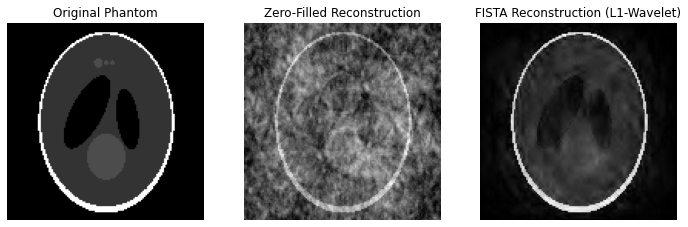

In [1]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# **2. マルチコイル感度マップの生成 (birdcage model, 4 coils)**
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# **3. Spiral k-space (Non-Cartesian サンプリング) の作成**
coords = mri.spiral(
    fov=0.3, N=N, f_sampling=1.0, R=3, ninterleaves=1, alpha=1.0, gm=0.04, sm=150
)

# **4. Non-Cartesian k-space の計算**
nufft_ops = [sp.linop.NUFFT(img_shape, coord=coords) for _ in range(num_coils)]
nufft_adjs = [op.H for op in nufft_ops]
ksp = np.array([nufft_ops[i](phantom * mps[i]) for i in range(num_coils)])

# **5. Zero-Filled Reconstruction (Adjoint NUFFT)**
img_zero_filled = np.sum([nufft_adjs[i](ksp[i]) for i in range(num_coils)], axis=0)

# **6. デバイス設定**
try:
    device = sp.Device(0)  # GPU
except:
    device = sp.Device(-1)  # CPU

device.use()

# **7. FISTA の設定**
lamda = 0.01  # L1-Wavelet 正則化の強さ
max_iter = 30  # 反復回数

# **8. FISTA による L1-Wavelet 正則化 MRI 再構成**
fista_app = mri.app.L1WaveletRecon(
    ksp, mps, lamda=lamda, coord=coords, device=device,
    max_iter=max_iter, save_objective_values=True
)

# **9. FISTA の実行**
reconstructed_img_fista = fista_app.run()

# **10. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(np.abs(reconstructed_img_fista), cmap="gray")
axs[2].set_title("FISTA Reconstruction (L1-Wavelet)")
axs[2].axis("off")

plt.show()


L1-Wavelet 正則化を用いた ADMM 再構成

L1WaveletRecon: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s, obj=1.11E+01]


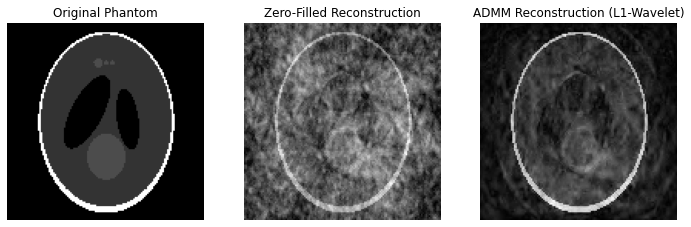

In [2]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# **2. マルチコイル感度マップの生成 (birdcage model, 4 coils)**
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# **3. Spiral k-space (Non-Cartesian サンプリング) の作成**
coords = mri.spiral(
    fov=0.3, N=N, f_sampling=1.0, R=3, ninterleaves=1, alpha=1.0, gm=0.04, sm=150
)

# **4. Non-Cartesian k-space の計算**
nufft_ops = [sp.linop.NUFFT(img_shape, coord=coords) for _ in range(num_coils)]
nufft_adjs = [op.H for op in nufft_ops]
ksp = np.array([nufft_ops[i](phantom * mps[i]) for i in range(num_coils)])

# **5. Zero-Filled Reconstruction (Adjoint NUFFT)**
img_zero_filled = np.sum([nufft_adjs[i](ksp[i]) for i in range(num_coils)], axis=0)

# **6. デバイス設定**
try:
    device = sp.Device(0)  # GPU
except:
    device = sp.Device(-1)  # CPU

device.use()

# **7. ADMM の設定**
lamda = 0.01  # L1-Wavelet 正則化の強さ
rho = 1  # ADMM のペナルティ係数
max_iter = 50  # 反復回数
max_cg_iter = 5  # ADMM の各ステップでの CG 反復数

# **8. ADMM による L1-Wavelet 正則化 MRI 再構成**
admm_app = mri.app.L1WaveletRecon(
    ksp, mps, solver='ADMM', lamda=lamda, coord=coords, device=device, rho=rho,
    max_iter=max_iter // max_cg_iter, max_cg_iter=max_cg_iter, save_objective_values=True
)

# **9. ADMM の実行**
reconstructed_img_admm = admm_app.run()

# **10. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(np.abs(reconstructed_img_admm), cmap="gray")
axs[2].set_title("ADMM Reconstruction (L1-Wavelet)")
axs[2].axis("off")

plt.show()


L1-Wavelet 正則化を用いた ADMM (Multi-Channel Preconditioner 付き)

L1WaveletRecon: 100%|██████████| 6/6 [00:00<00:00,  8.39it/s, obj=1.34E+01]


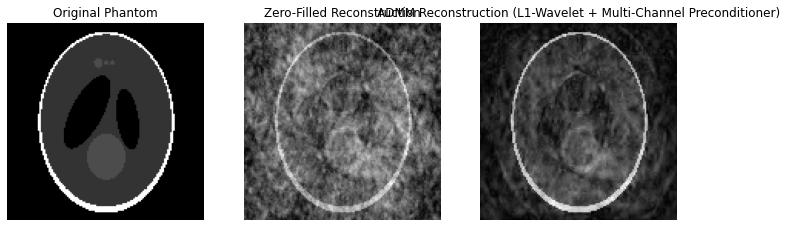

In [6]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# **2. マルチコイル感度マップの生成 (birdcage model, 4 coils)**
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# **3. Spiral k-space (Non-Cartesian サンプリング) の作成**
coords = mri.spiral(
    fov=0.3, N=N, f_sampling=1.0, R=3, ninterleaves=1, alpha=1.0, gm=0.04, sm=150
)

# **4. Non-Cartesian k-space の計算**
nufft_ops = [sp.linop.NUFFT(img_shape, coord=coords) for _ in range(num_coils)]
nufft_adjs = [op.H for op in nufft_ops]
ksp = np.array([nufft_ops[i](phantom * mps[i]) for i in range(num_coils)])

# **5. Zero-Filled Reconstruction (Adjoint NUFFT)**
img_zero_filled = np.sum([nufft_adjs[i](ksp[i]) for i in range(num_coils)], axis=0)

# **6. デバイス設定**
try:
    device = sp.Device(0)  # GPU
except:
    device = sp.Device(-1)  # CPU

device.use()

# **7. Multi-Channel Preconditioner (k-space Preconditioner) の計算**
precond_mc = mri.kspace_precond(mps, coord=coords, device=device)

# **8. ADMM の設定**
lamda = 0.01  # L1-Wavelet 正則化の強さ
rho = 1.0  # ADMM のペナルティ係数
max_iter = 30  # 反復回数
max_cg_iter = 5  # 内部 CG 反復回数

# **9. ADMM + Multi-Channel Preconditioner による L1-Wavelet 正則化 MRI 再構成**
admm_mc_app = mri.app.L1WaveletRecon(
    ksp, mps, solver='ADMM', lamda=lamda, coord=coords, sigma=precond_mc,
    rho=rho, device=device, max_iter=max_iter // max_cg_iter,
    max_cg_iter=max_cg_iter, save_objective_values=True
)

# **10. ADMM + Multi-Channel Preconditioner の実行**
reconstructed_img_admm_mc = admm_mc_app.run()

# **11. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(np.abs(reconstructed_img_admm_mc), cmap="gray")
axs[2].set_title("ADMM Reconstruction (L1-Wavelet + Multi-Channel Preconditioner)")
axs[2].axis("off")

plt.show()


L1-Wavelet 正則化を用いた PDHG 再構成

L1WaveletRecon: 100%|██████████| 30/30 [00:00<00:00, 34.65it/s, obj=8.33E+00]


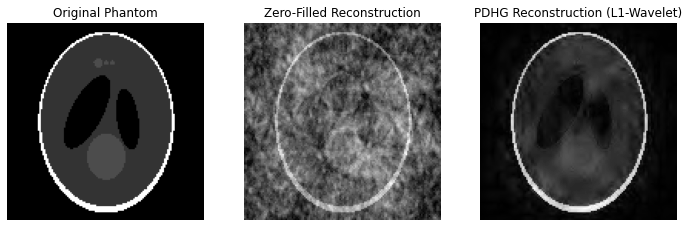

In [3]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# **2. マルチコイル感度マップの生成 (birdcage model, 4 coils)**
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# **3. Spiral k-space (Non-Cartesian サンプリング) の作成**
coords = mri.spiral(
    fov=0.3, N=N, f_sampling=1.0, R=3, ninterleaves=1, alpha=1.0, gm=0.04, sm=150
)

# **4. Non-Cartesian k-space の計算**
nufft_ops = [sp.linop.NUFFT(img_shape, coord=coords) for _ in range(num_coils)]
nufft_adjs = [op.H for op in nufft_ops]
ksp = np.array([nufft_ops[i](phantom * mps[i]) for i in range(num_coils)])

# **5. Zero-Filled Reconstruction (Adjoint NUFFT)**
img_zero_filled = np.sum([nufft_adjs[i](ksp[i]) for i in range(num_coils)], axis=0)

# **6. デバイス設定**
try:
    device = sp.Device(0)  # GPU
except:
    device = sp.Device(-1)  # CPU

device.use()

# **7. PDHG の設定**
lamda = 0.01  # L1-Wavelet 正則化の強さ
max_iter = 30  # 反復回数

# **8. PDHG による L1-Wavelet 正則化 MRI 再構成**
pdhg_app = mri.app.L1WaveletRecon(
    ksp, mps, lamda=lamda, coord=coords, device=device,
    max_iter=max_iter, solver='PrimalDualHybridGradient', save_objective_values=True
)

# **9. PDHG の実行**
reconstructed_img_pdhg = pdhg_app.run()

# **10. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(np.abs(reconstructed_img_pdhg), cmap="gray")
axs[2].set_title("PDHG Reconstruction (L1-Wavelet)")
axs[2].axis("off")

plt.show()


L1-Wavelet 正則化を用いた PDHG (Multi-Channel Preconditioner 付き)

L1WaveletRecon: 100%|██████████| 30/30 [00:00<00:00, 33.19it/s, obj=8.05E+00]


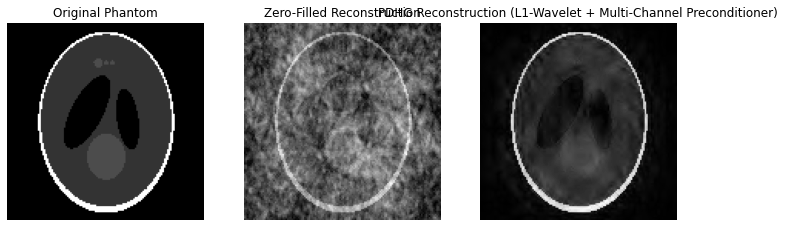

In [5]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# **2. マルチコイル感度マップの生成 (birdcage model, 4 coils)**
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# **3. Spiral k-space (Non-Cartesian サンプリング) の作成**
coords = mri.spiral(
    fov=0.3, N=N, f_sampling=1.0, R=3, ninterleaves=1, alpha=1.0, gm=0.04, sm=150
)

# **4. Non-Cartesian k-space の計算**
nufft_ops = [sp.linop.NUFFT(img_shape, coord=coords) for _ in range(num_coils)]
nufft_adjs = [op.H for op in nufft_ops]
ksp = np.array([nufft_ops[i](phantom * mps[i]) for i in range(num_coils)])

# **5. Zero-Filled Reconstruction (Adjoint NUFFT)**
img_zero_filled = np.sum([nufft_adjs[i](ksp[i]) for i in range(num_coils)], axis=0)

# **6. デバイス設定**
try:
    device = sp.Device(0)  # GPU
except:
    device = sp.Device(-1)  # CPU

device.use()

# **7. Multi-Channel Preconditioner (k-space Preconditioner) の計算**
precond_mc = mri.kspace_precond(mps, coord=coords, device=device)

# **8. PDHG の設定**
lamda = 0.01  # L1-Wavelet 正則化の強さ
max_iter = 30  # 反復回数

# **9. PDHG + Multi-Channel Preconditioner による L1-Wavelet 正則化 MRI 再構成**
pdhg_mc_app = mri.app.L1WaveletRecon(
    ksp, mps, lamda=lamda, coord=coords, sigma=precond_mc, device=device,
    max_iter=max_iter, solver='PrimalDualHybridGradient', save_objective_values=True
)

# **10. PDHG + Multi-Channel Preconditioner の実行**
reconstructed_img_pdhg_mc = pdhg_mc_app.run()

# **11. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(np.abs(reconstructed_img_pdhg_mc), cmap="gray")
axs[2].set_title("PDHG Reconstruction (L1-Wavelet + Multi-Channel Preconditioner)")
axs[2].axis("off")

plt.show()
